# Spiking neural networks for audio analysis

In [1]:
import os
import sys
sys.path.append("..")
import time
import numpy as np
import librosa
import scipy.io.wavfile as wav
from tqdm import tqdm_notebook
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader
import torchvision


from utils import plot_spk_rec, plot_mem_rec, generate_random_silence_files
from models import SNN, SpikingConv2DLayer, ReadoutLayer, SurrogateHeaviside, SpikingDenseLayer

from data import SpeechCommandsDataset,Pad, MelSpectrogram, Rescale
from optim import RAdam

In [2]:
import warnings
warnings.filterwarnings("ignore", category=wav.WavFileWarning)

In [3]:
dtype = torch.float
device = torch.device("cuda:0")

# Loading Data

In [4]:
train_data_root = "../data/train"
test_data_root = "../data/test"

training_words = os.listdir(train_data_root)
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x))]
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x)) if x[0] != "_" ]
print("{} training words:".format(len(training_words)))
print(training_words)

30 training words:
['bed', 'yes', 'stop', 'no', 'three', 'right', 'one', 'four', 'two', 'up', 'left', 'five', 'cat', 'dog', 'eight', 'bird', 'happy', 'on', 'down', 'sheila', 'zero', 'wow', 'marvin', 'house', 'six', 'off', 'seven', 'tree', 'nine', 'go']


In [5]:
testing_words = os.listdir(test_data_root)
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x))]
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x)) 
                 if x[0] != "_"]
print("{} testing words:".format(len(testing_words)))
print(testing_words)

10 testing words:
['yes', 'stop', 'no', 'right', 'up', 'left', 'on', 'down', 'off', 'go']


In [6]:
label_dct = {k:i for i,k in enumerate(testing_words + ["_silence_", "_unknown_"])}
for w in training_words:
    label = label_dct.get(w)
    if label is None:
        label_dct[w] = label_dct["_unknown_"]

print("label_dct:")
print(label_dct)

label_dct:
{'yes': 0, 'stop': 1, 'no': 2, 'right': 3, 'up': 4, 'left': 5, 'on': 6, 'down': 7, 'off': 8, 'go': 9, '_silence_': 10, '_unknown_': 11, 'bed': 11, 'three': 11, 'one': 11, 'four': 11, 'two': 11, 'five': 11, 'cat': 11, 'dog': 11, 'eight': 11, 'bird': 11, 'happy': 11, 'sheila': 11, 'zero': 11, 'wow': 11, 'marvin': 11, 'house': 11, 'six': 11, 'seven': 11, 'tree': 11, 'nine': 11}


In [7]:
sr = 16000
size = 16000

In [8]:
noise_path = os.path.join(train_data_root, "_background_noise_")
noise_files = []
for f in os.listdir(noise_path):
    if f.endswith(".wav"):
        full_name = os.path.join(noise_path, f)
        noise_files.append(full_name)
print("noise files:")
print(noise_files)

noise files:
['data/train/_background_noise_/pink_noise.wav', 'data/train/_background_noise_/dude_miaowing.wav', 'data/train/_background_noise_/exercise_bike.wav', 'data/train/_background_noise_/doing_the_dishes.wav', 'data/train/_background_noise_/running_tap.wav', 'data/train/_background_noise_/white_noise.wav']


In [9]:
# generate silence training and validation data

silence_folder = os.path.join(train_data_root, "_silence_")
if not os.path.exists(silence_folder):
    os.makedirs(silence_folder)
    # 260 validation / 2300 training
    generate_random_silence_files(2560, noise_files, size, os.path.join(silence_folder, "rd_silence"))

    # save 260 files for validation
    silence_files = [fname for fname in os.listdir(silence_folder)]
    with open(os.path.join(train_data_root, "silence_validation_list.txt"),"w") as f:
        f.writelines("_silence_/"+ fname + "\n" for fname in silence_files[:260])

In [10]:
n_fft = int(30e-3*sr)
hop_length = int(10e-3*sr)
n_mels = 40
fmax = 4000
fmin = 20
delta_order = 2
stack = True

melspec = MelSpectrogram(sr, n_fft, hop_length, n_mels, fmin, fmax, delta_order, stack=stack)
pad = Pad(size)
rescale = Rescale()


transform = torchvision.transforms.Compose([pad,
                                 melspec,
                                 rescale])


def collate_fn(data):
    
    X_batch = np.array([d[0] for d in data])
    std = X_batch.std(axis=(0,2), keepdims=True)
    X_batch = torch.tensor(X_batch/std)
    
    y_batch = torch.tensor([d[1] for d in data])
    
    return X_batch, y_batch    

In [11]:
batch_size = 64

train_dataset = SpeechCommandsDataset(train_data_root, label_dct, transform = transform, mode="train", max_nb_per_class=None)
train_sampler = torch.utils.data.WeightedRandomSampler(train_dataset.weights,len(train_dataset.weights))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, sampler=train_sampler, collate_fn=collate_fn)

valid_dataset = SpeechCommandsDataset(train_data_root, label_dct, transform = transform, mode="valid", max_nb_per_class=None)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

test_dataset = SpeechCommandsDataset(test_data_root, label_dct, transform = transform, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Creating the model

In [12]:
spike_fn = SurrogateHeaviside.apply

w_init_std = 0.15
w_init_mean = 0.

layers = []
in_channels = 3
out_channels = 64
kernel_size = (4,3)
dilation = (1,1)
input_shape = n_mels
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True))


in_channels = out_channels
out_channels = 64
kernel_size = (4,3)
dilation = (4,3)
input_shape = output_shape
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                              lateral_connections=True))

in_channels = out_channels
out_channels = 64
kernel_size = (4,3)
dilation = (16,9)
input_shape = output_shape
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True, flatten_output=True))

# previous layer output has been flattened
input_shape = output_shape*out_channels
output_shape = 12
time_reduction="mean" #mean or max
layers.append(ReadoutLayer(input_shape, output_shape,
                 w_init_mean=w_init_mean, w_init_std=w_init_std, time_reduction=time_reduction))

snn = SNN(layers).to(device, dtype)

X_batch, _ = next(iter(train_dataloader))
X_batch = X_batch.to(device, dtype)
snn(X_batch)

for i,l in enumerate(snn.layers):
    if isinstance(l, SpikingDenseLayer) or isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))

Layer 0: average number of spikes=0.1289
Layer 1: average number of spikes=0.1222
Layer 2: average number of spikes=0.1367


# Training and plotting

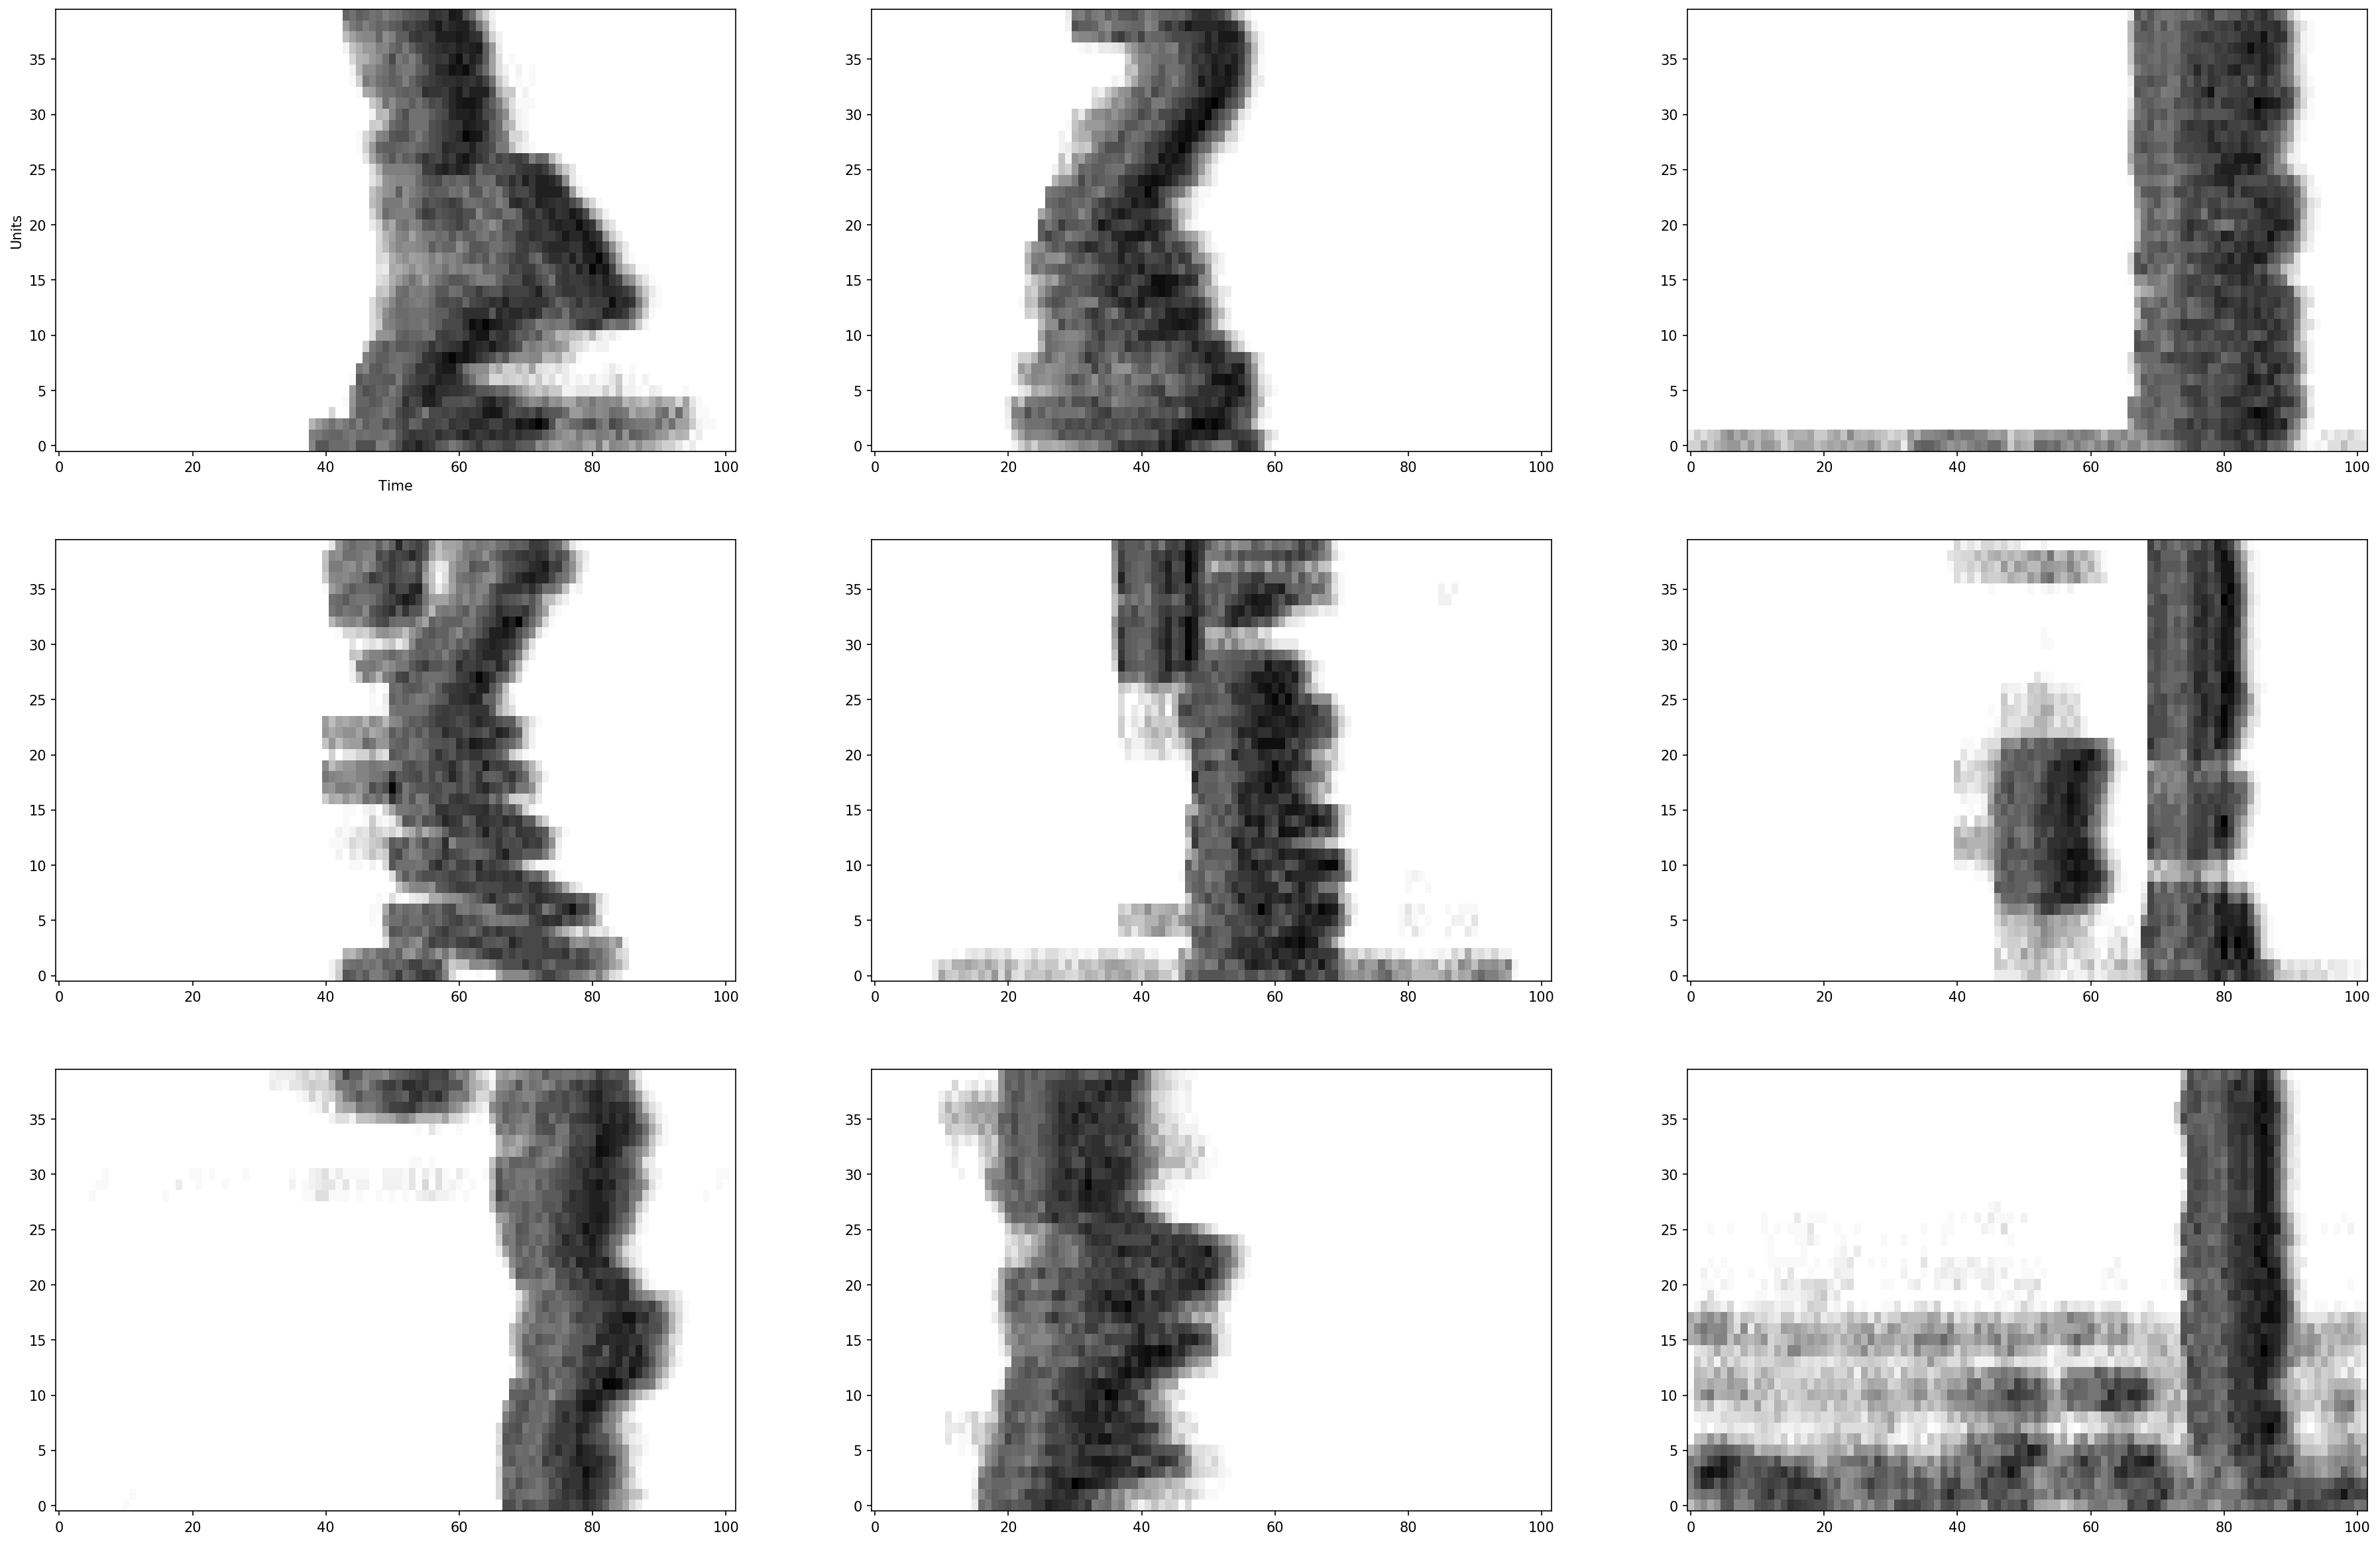

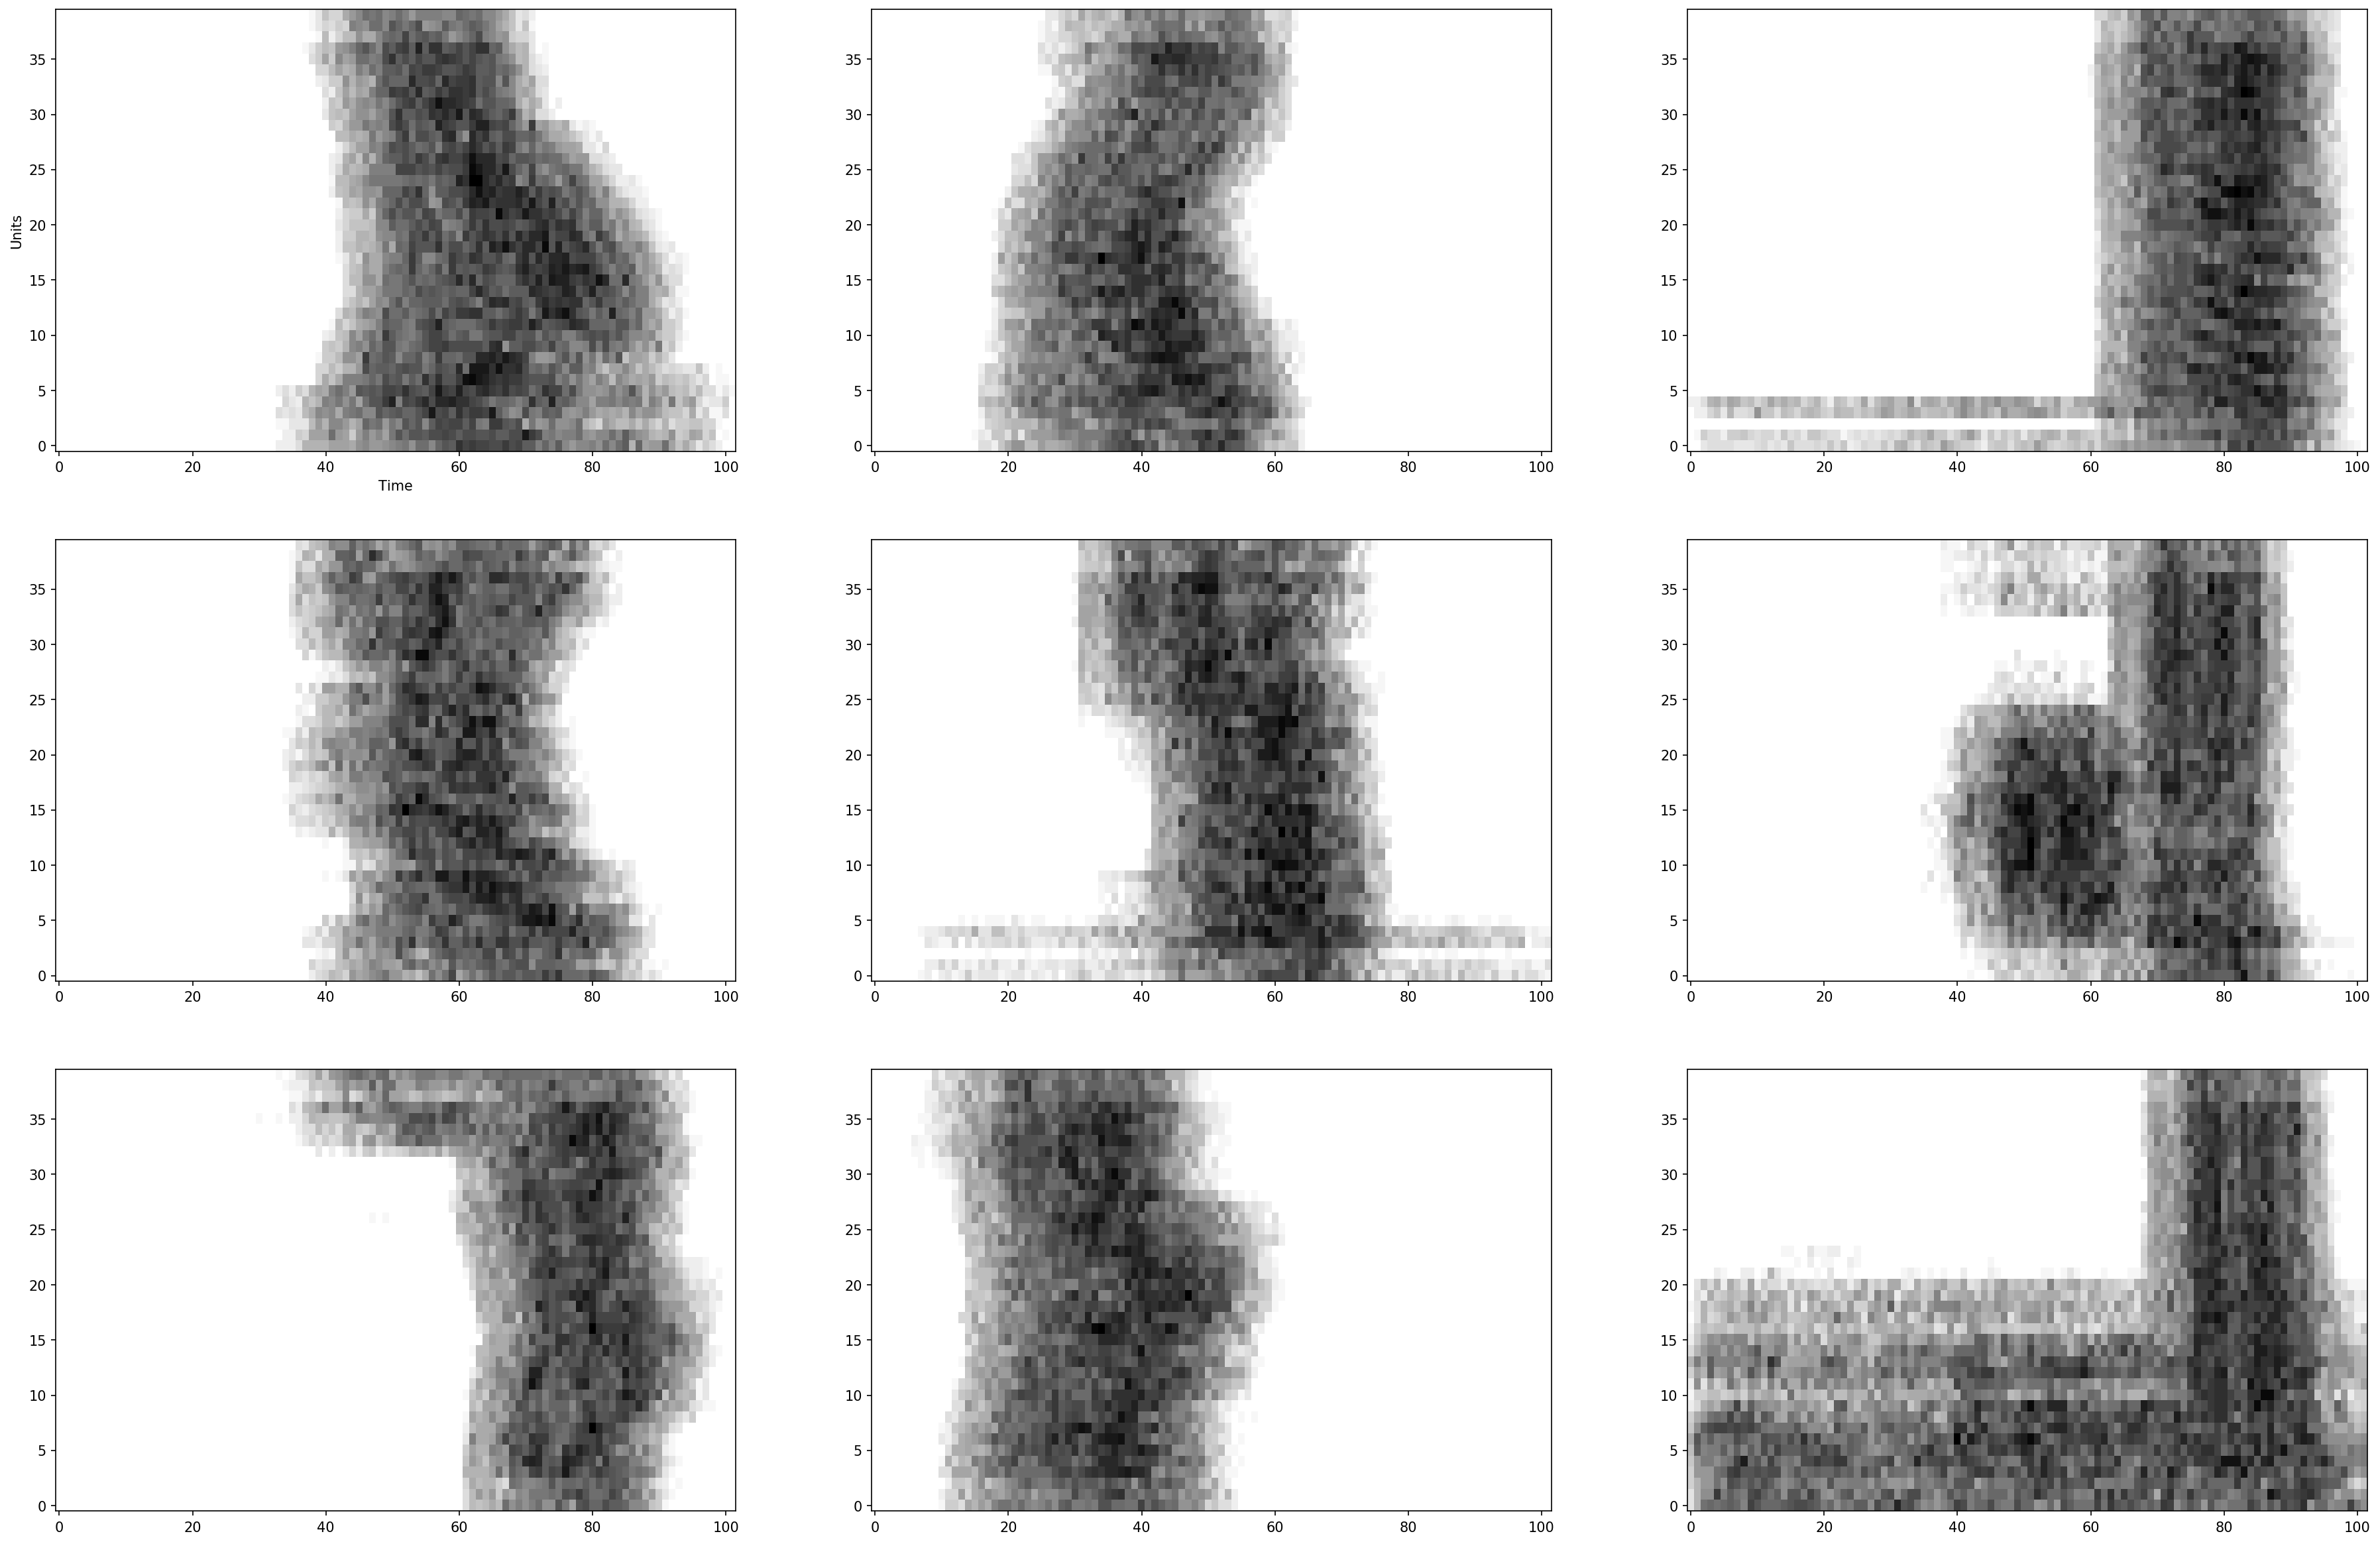

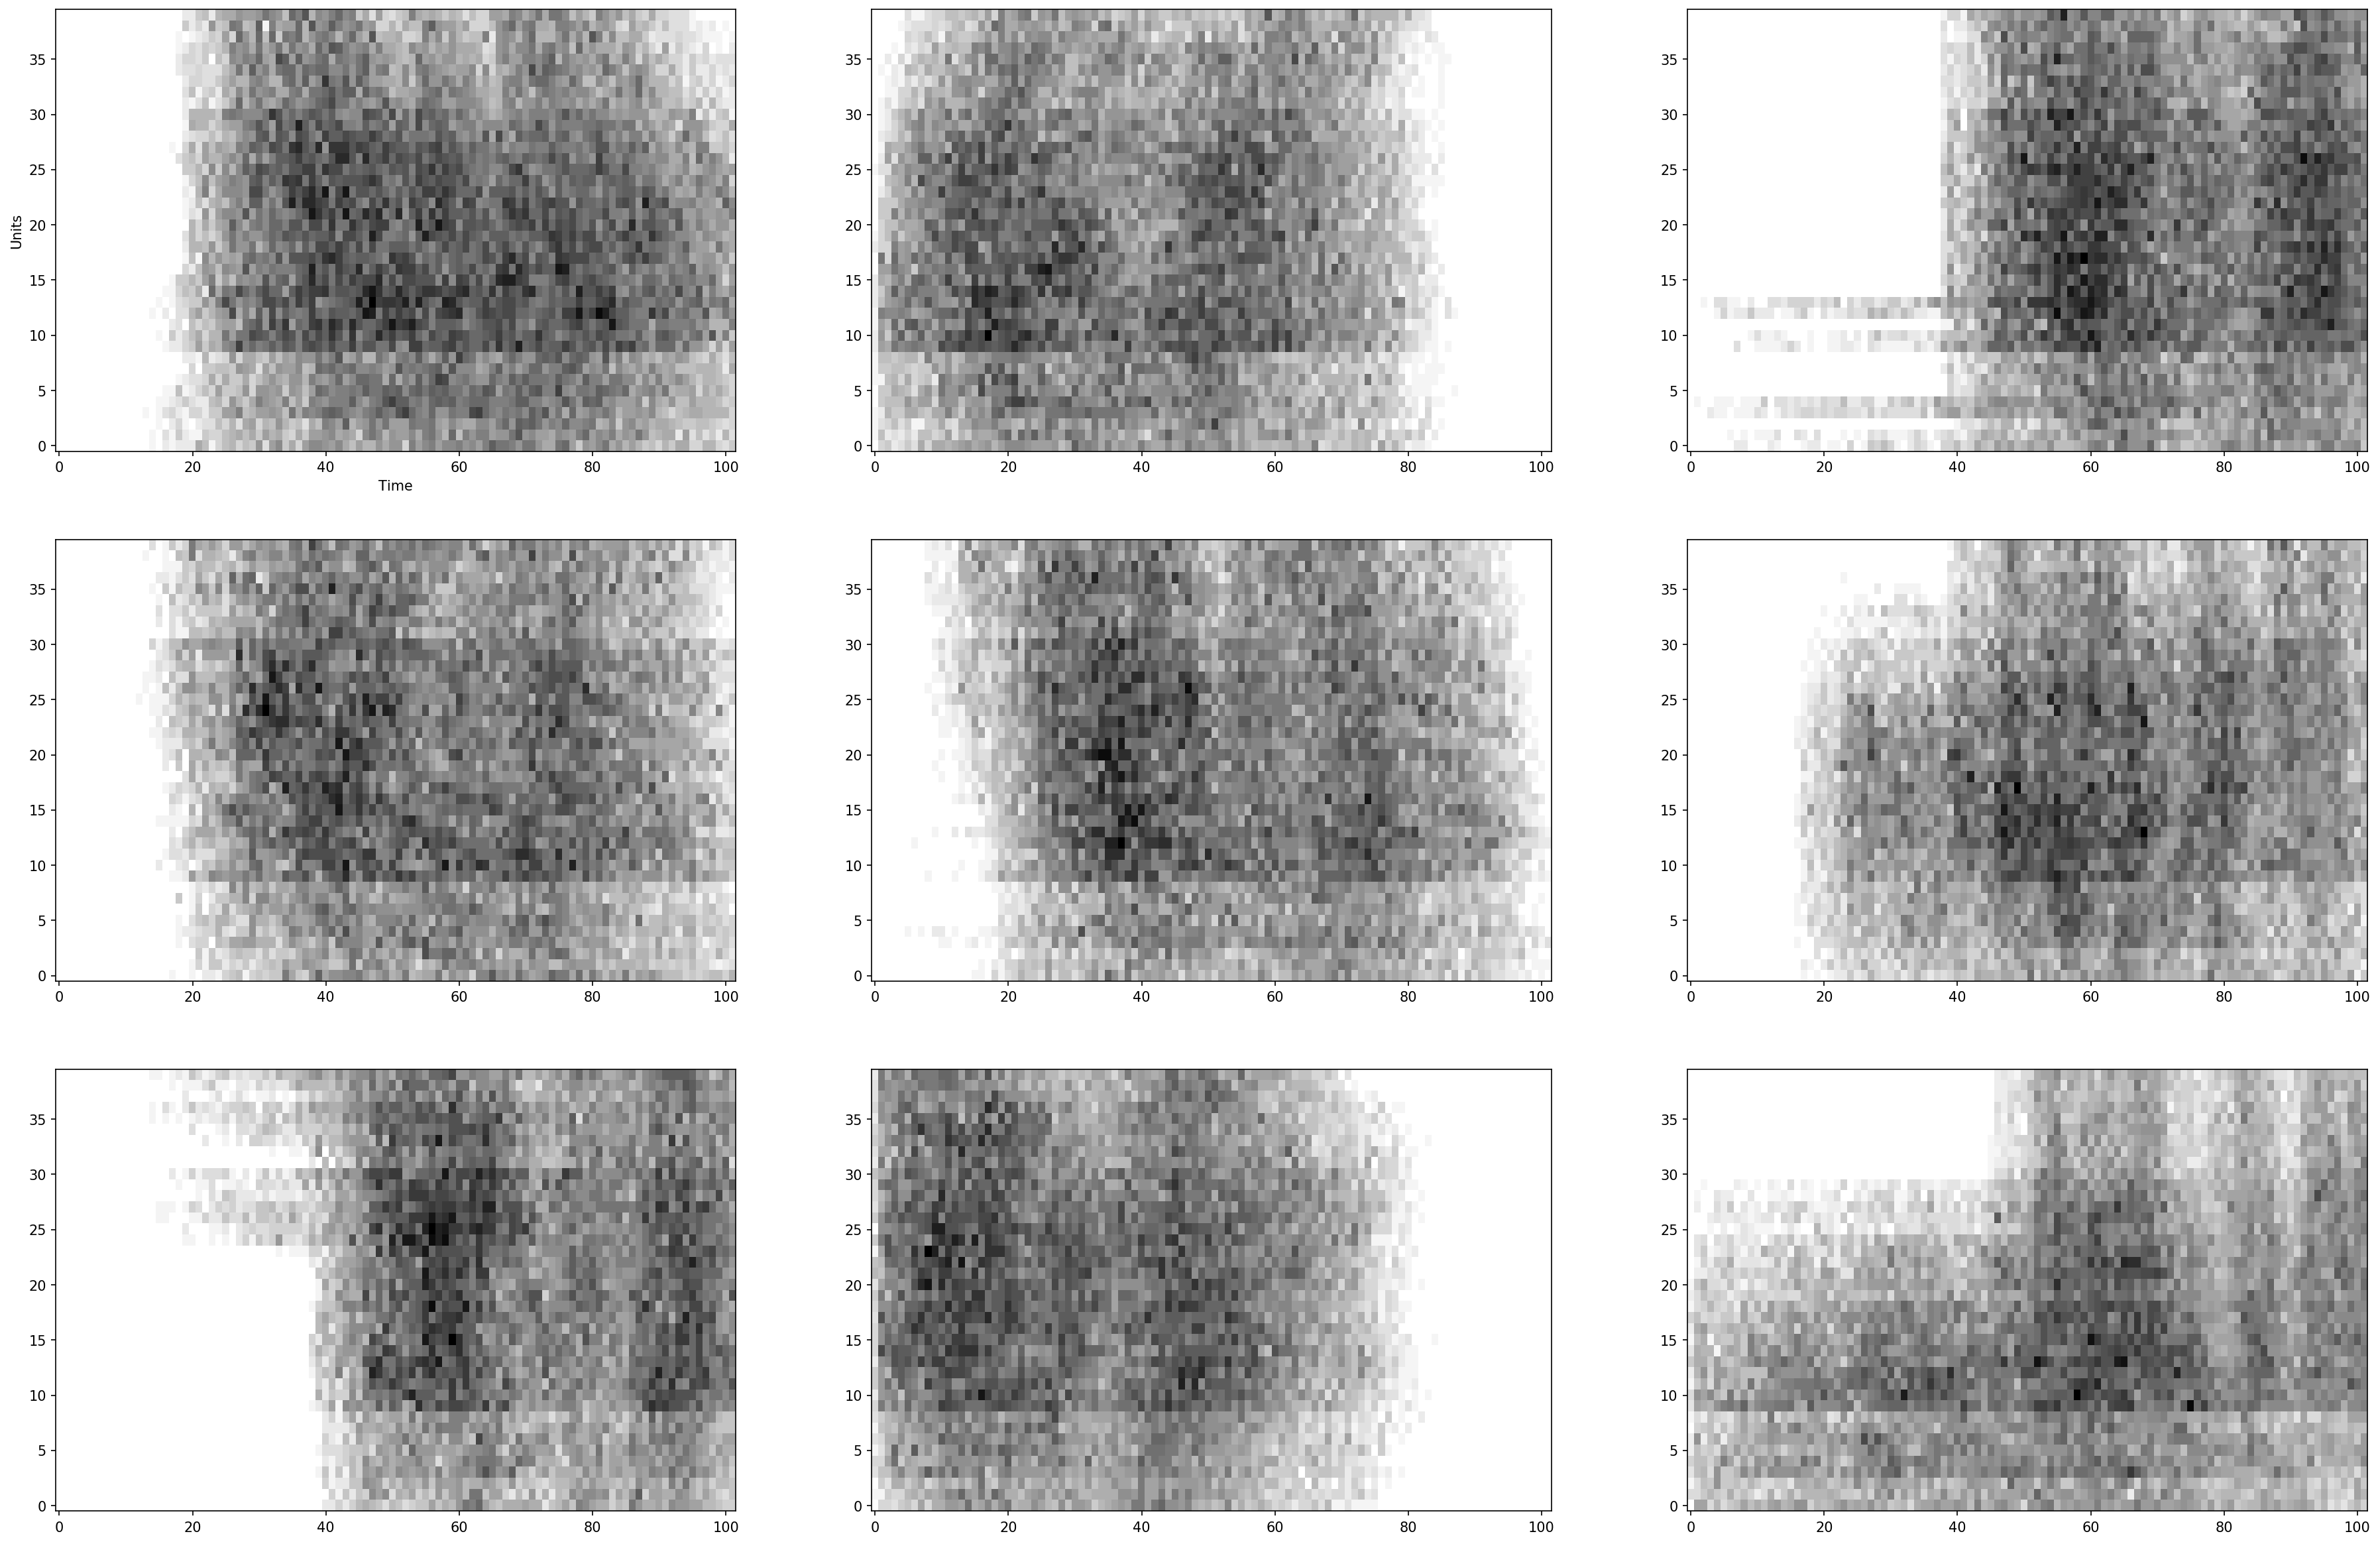

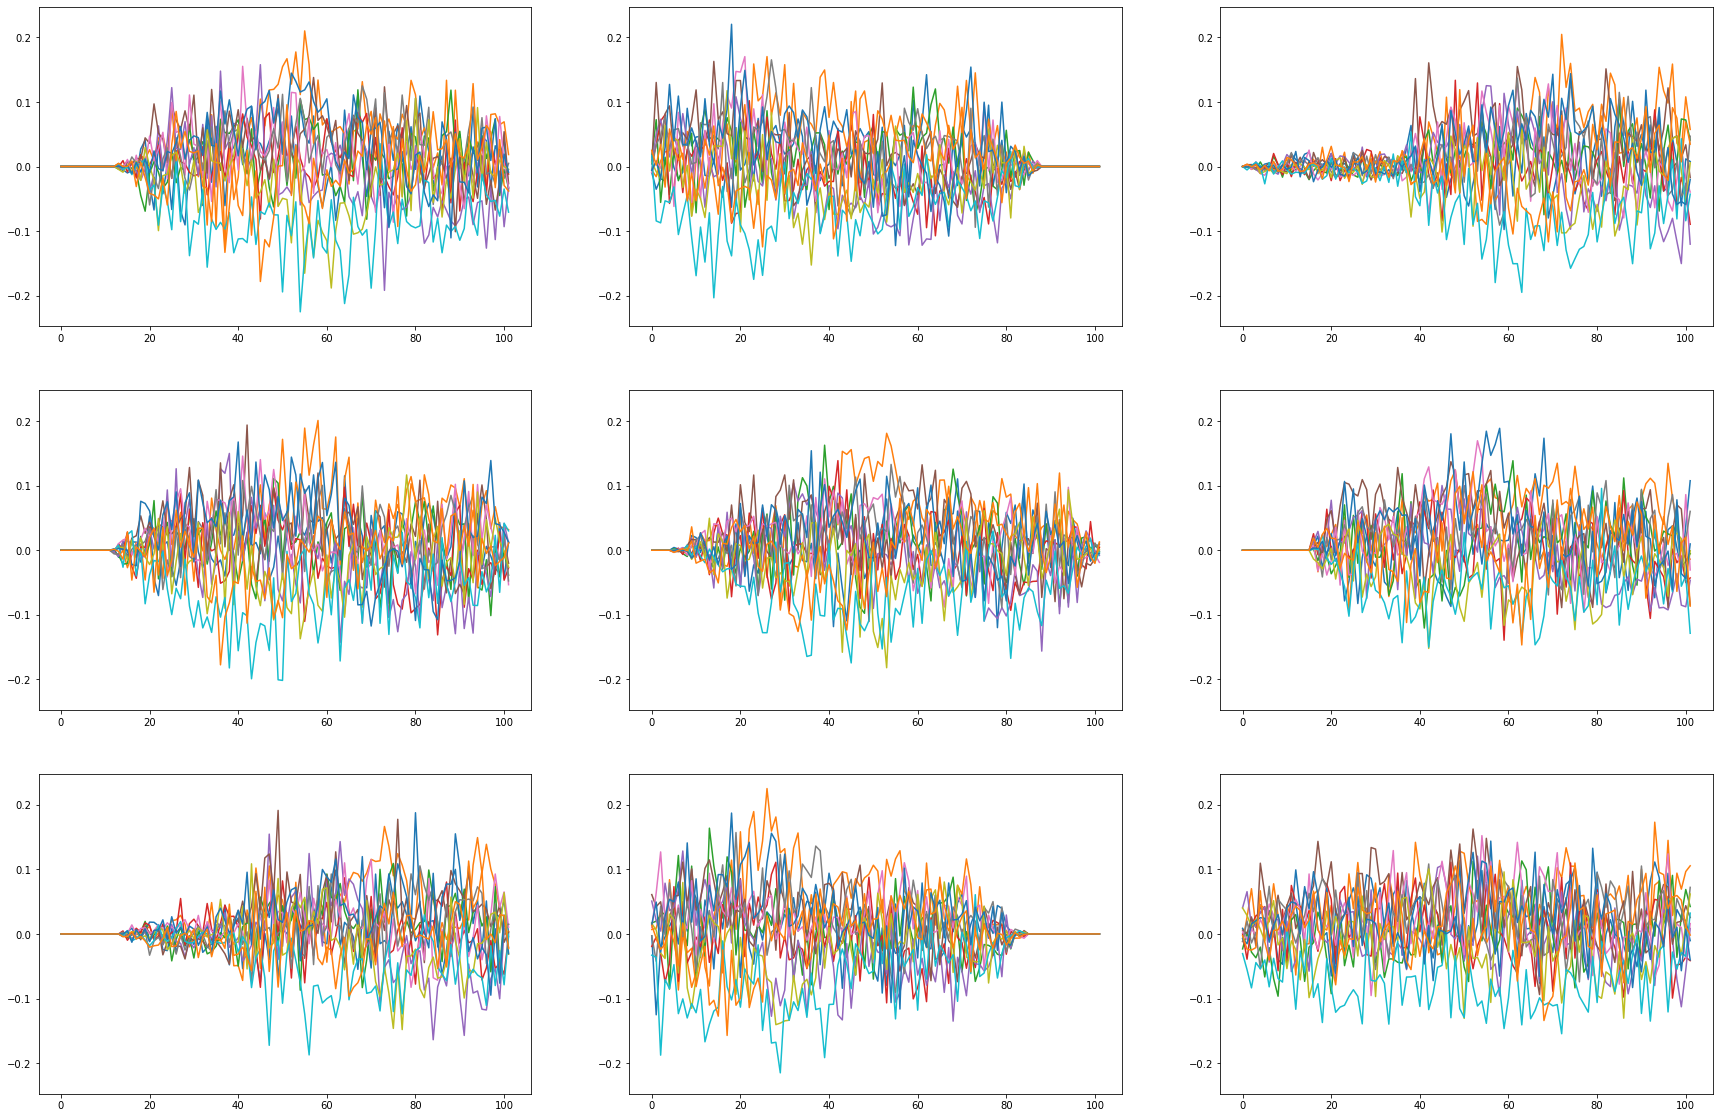

In [13]:
nb_plt = 9

batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [14]:
def train(model, params, optimizer, train_dataloader, valid_dataloader, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
    
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= len(train_dataloader)*warmup_epochs
        warmup_itr = 1
    
    hist = {'loss':[], 'valid_accuracy':[]}
    for e in range(nb_epochs):
        local_loss = []
        reg_loss = [[] for _ in range(len(model.layers)-1)]
        
        #with tqdm_notebook(total=len(train_dataloader)) as pb:
        for x_batch, y_batch in train_dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)

            output, loss_seq = model(x_batch)
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch)
            local_loss.append(loss_val.item())

            for i,loss in enumerate(loss_seq[:-1]):
                reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
                loss_val += reg_loss_val
                reg_loss[i].append(reg_loss_val.item())


            optimizer.zero_grad()
            loss_val.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            optimizer.step()
            model.clamp()

            if e < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] *= (warmup_itr+1)/(warmup_itr)
                warmup_itr += 1
                
                #pb.update(1)
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        for i,loss in enumerate(reg_loss):
            mean_reg_loss = np.mean(loss)
            print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(snn.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        
        valid_accuracy = compute_classification_accuracy(model, valid_dataloader)
        hist['valid_accuracy'].append(valid_accuracy)
        print("Validation accuracy=%.3f"%(valid_accuracy))
        
    return hist
        
def compute_classification_accuracy(model, dataloader):
    accs = []
    
    with torch.no_grad():
        #with tqdm_notebook(total=len(dataloader)) as pb:
        for x_batch, y_batch in dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
                #pb.update(1)
    return np.mean(accs)

In [15]:
lr = 1e-3
weight_decay = 1e-5
reg_loss_coef = 0.1
nb_epochs = 10

params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(snn.layers)]
params += [{'params':l.v, 'lr':lr, "weight_decay":weight_decay} for i,l in enumerate(snn.layers[:-1]) if l.recurrent]
params += [{'params':l.b, 'lr':lr} for i,l in enumerate(snn.layers)]
if snn.layers[-1].time_reduction == "mean":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers[:-1])]
elif snn.layers[-1].time_reduction == "max":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers)]
else:
    raise ValueError("Readout time recution should be 'max' or 'mean'")
    
optimizer = RAdam(params)
 
gamma = 0.85
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

hist = train(snn, params, optimizer, train_dataloader, test_dataloader, reg_loss_coef, nb_epochs=nb_epochs,
                  scheduler=scheduler, warmup_epochs=1)

Epoch 1: loss=0.85800
Layer 0: reg loss=0.00198
Layer 1: reg loss=0.00357
Layer 2: reg loss=0.00515
Layer 0: average number of spikes=0.0762
Layer 1: average number of spikes=0.0698
Layer 2: average number of spikes=0.0755
Validation accuracy=0.851
Epoch 2: loss=0.31405
Layer 0: reg loss=0.00109
Layer 1: reg loss=0.00214
Layer 2: reg loss=0.00321
Layer 0: average number of spikes=0.0530
Layer 1: average number of spikes=0.0565
Layer 2: average number of spikes=0.0666
Validation accuracy=0.889
Epoch 3: loss=0.24426
Layer 0: reg loss=0.00083
Layer 1: reg loss=0.00188
Layer 2: reg loss=0.00313
Layer 0: average number of spikes=0.0488
Layer 1: average number of spikes=0.0594
Layer 2: average number of spikes=0.0586
Validation accuracy=0.898
Epoch 4: loss=0.22020
Layer 0: reg loss=0.00071
Layer 1: reg loss=0.00180
Layer 2: reg loss=0.00305
Layer 0: average number of spikes=0.0397
Layer 1: average number of spikes=0.0504
Layer 2: average number of spikes=0.0562
Validation accuracy=0.884
Epoc

In [16]:
test_accuracy = compute_classification_accuracy(snn, test_dataloader)
print("Test accuracy=%.3f"%(test_accuracy))

Test accuracy=0.933


Layer 0: average number of spikes=0.0228
Layer 1: average number of spikes=0.0457
Layer 2: average number of spikes=0.0486


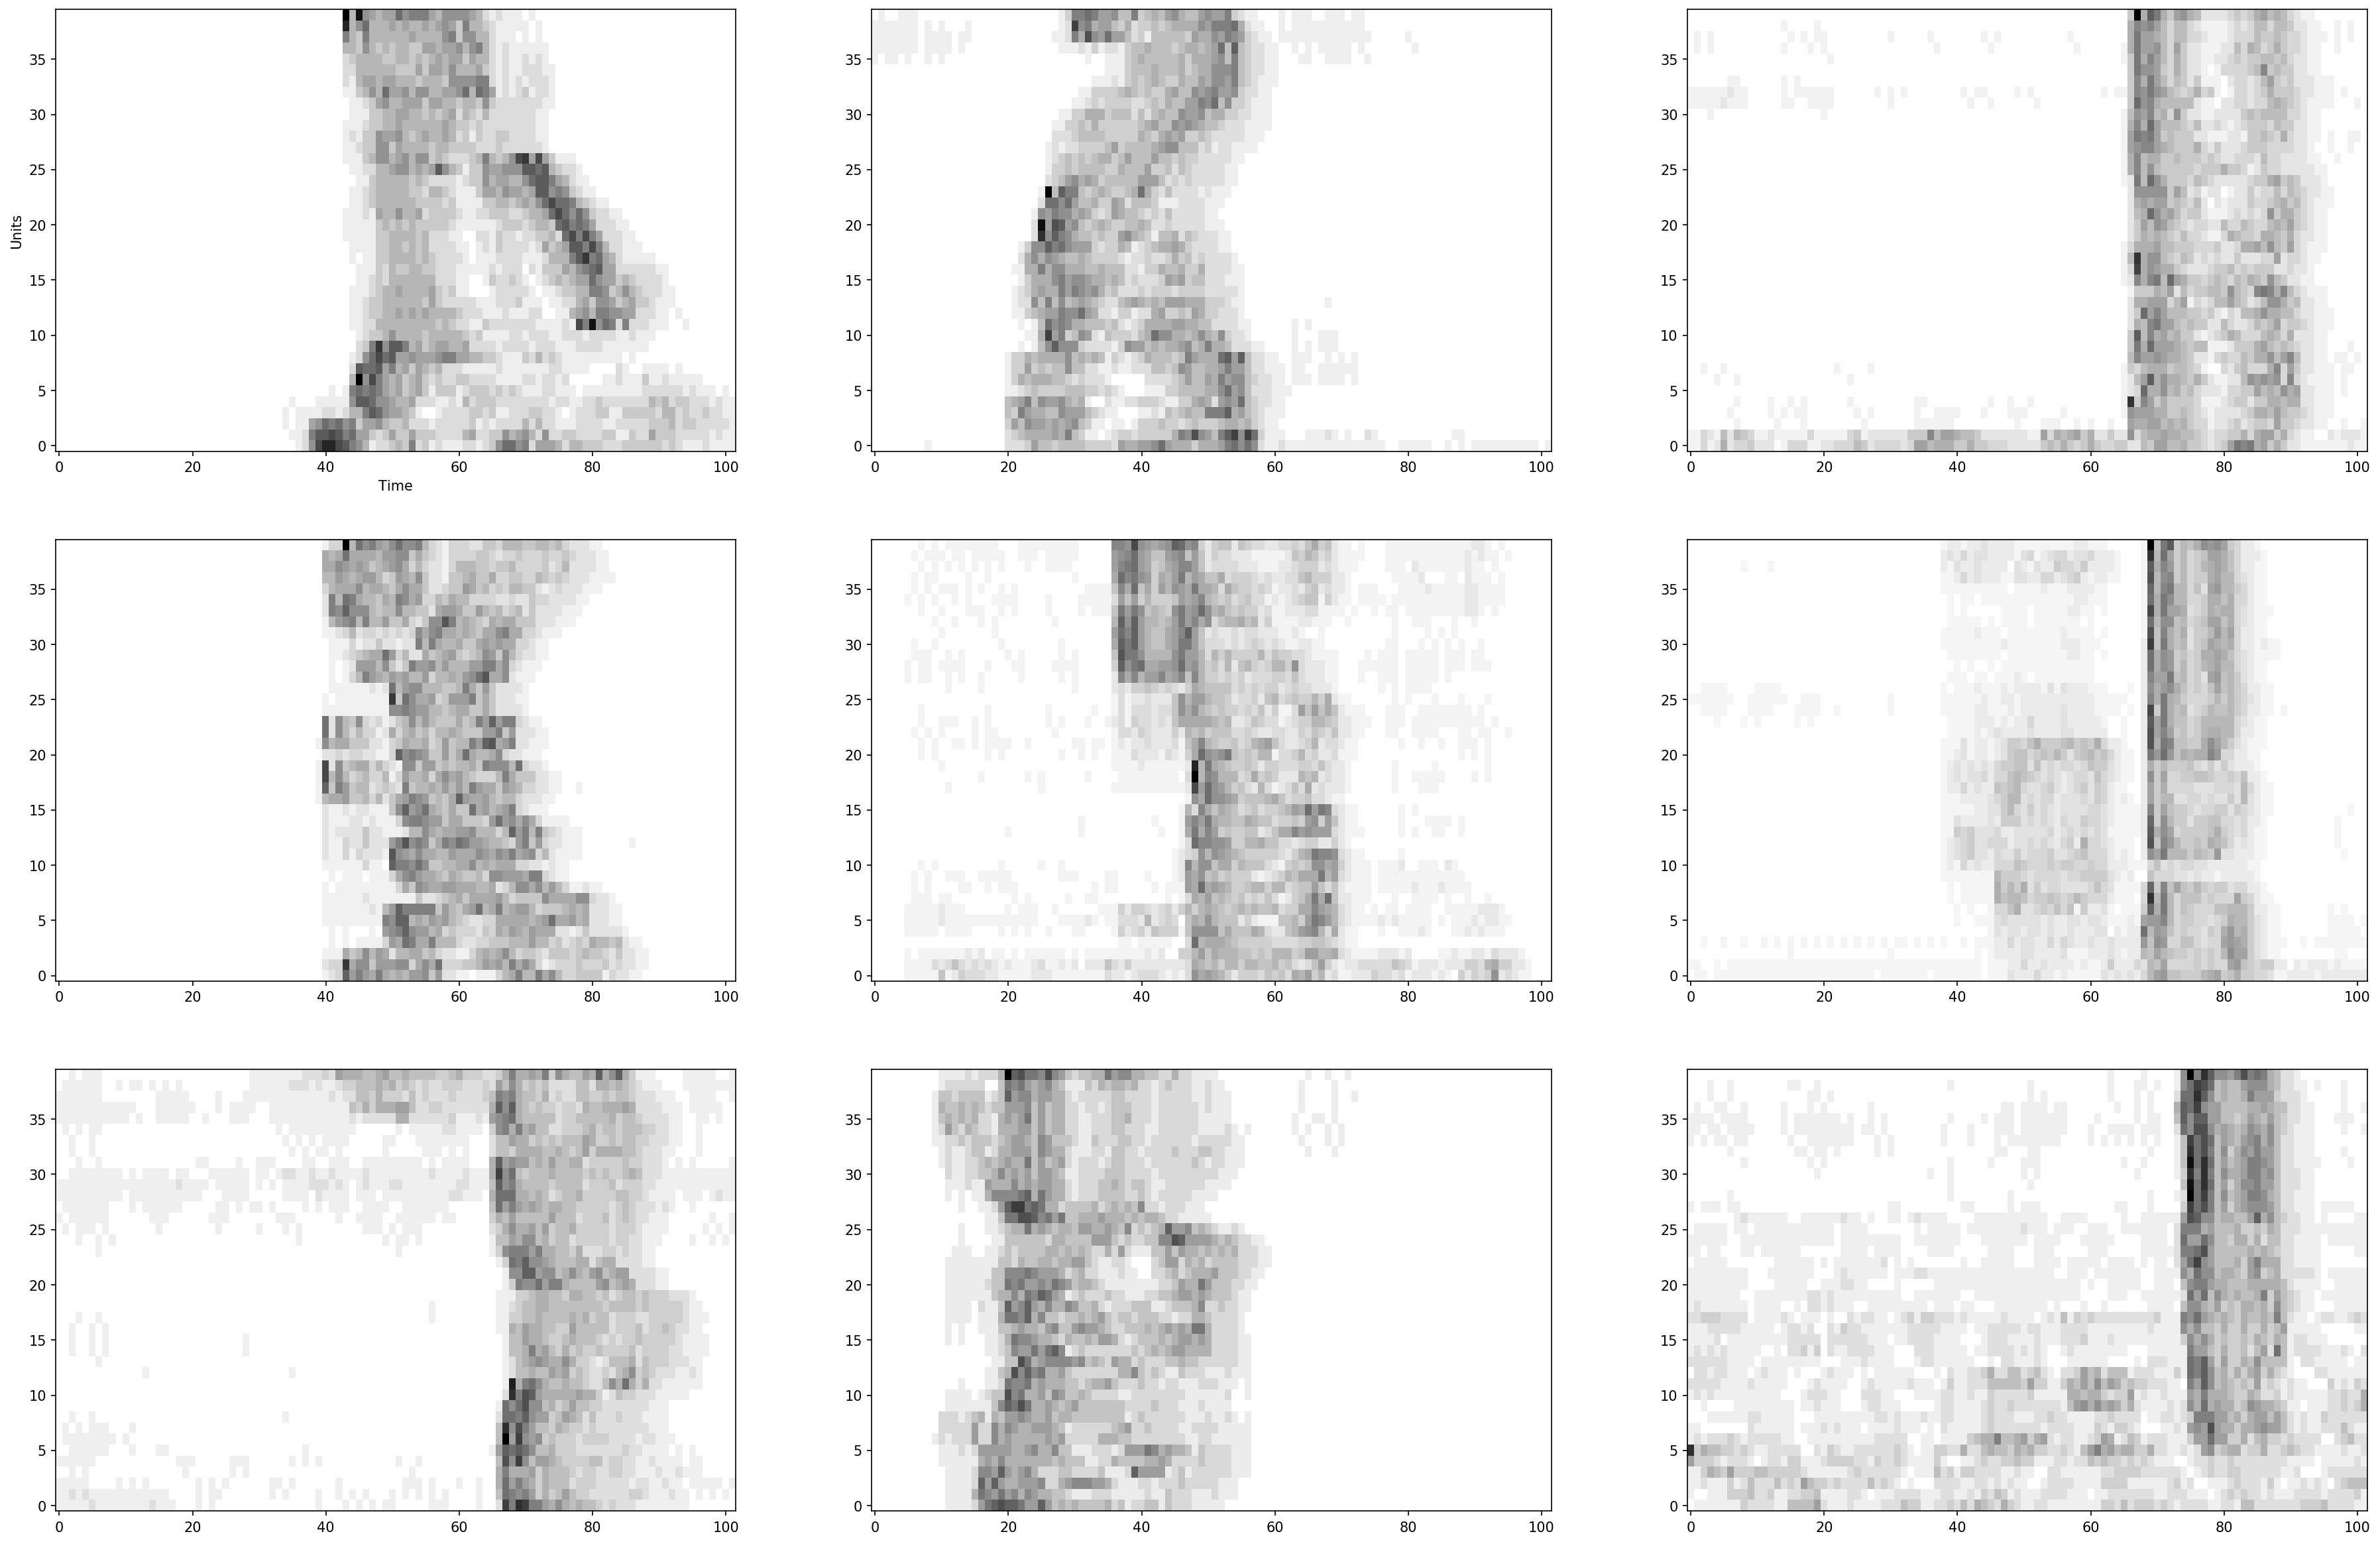

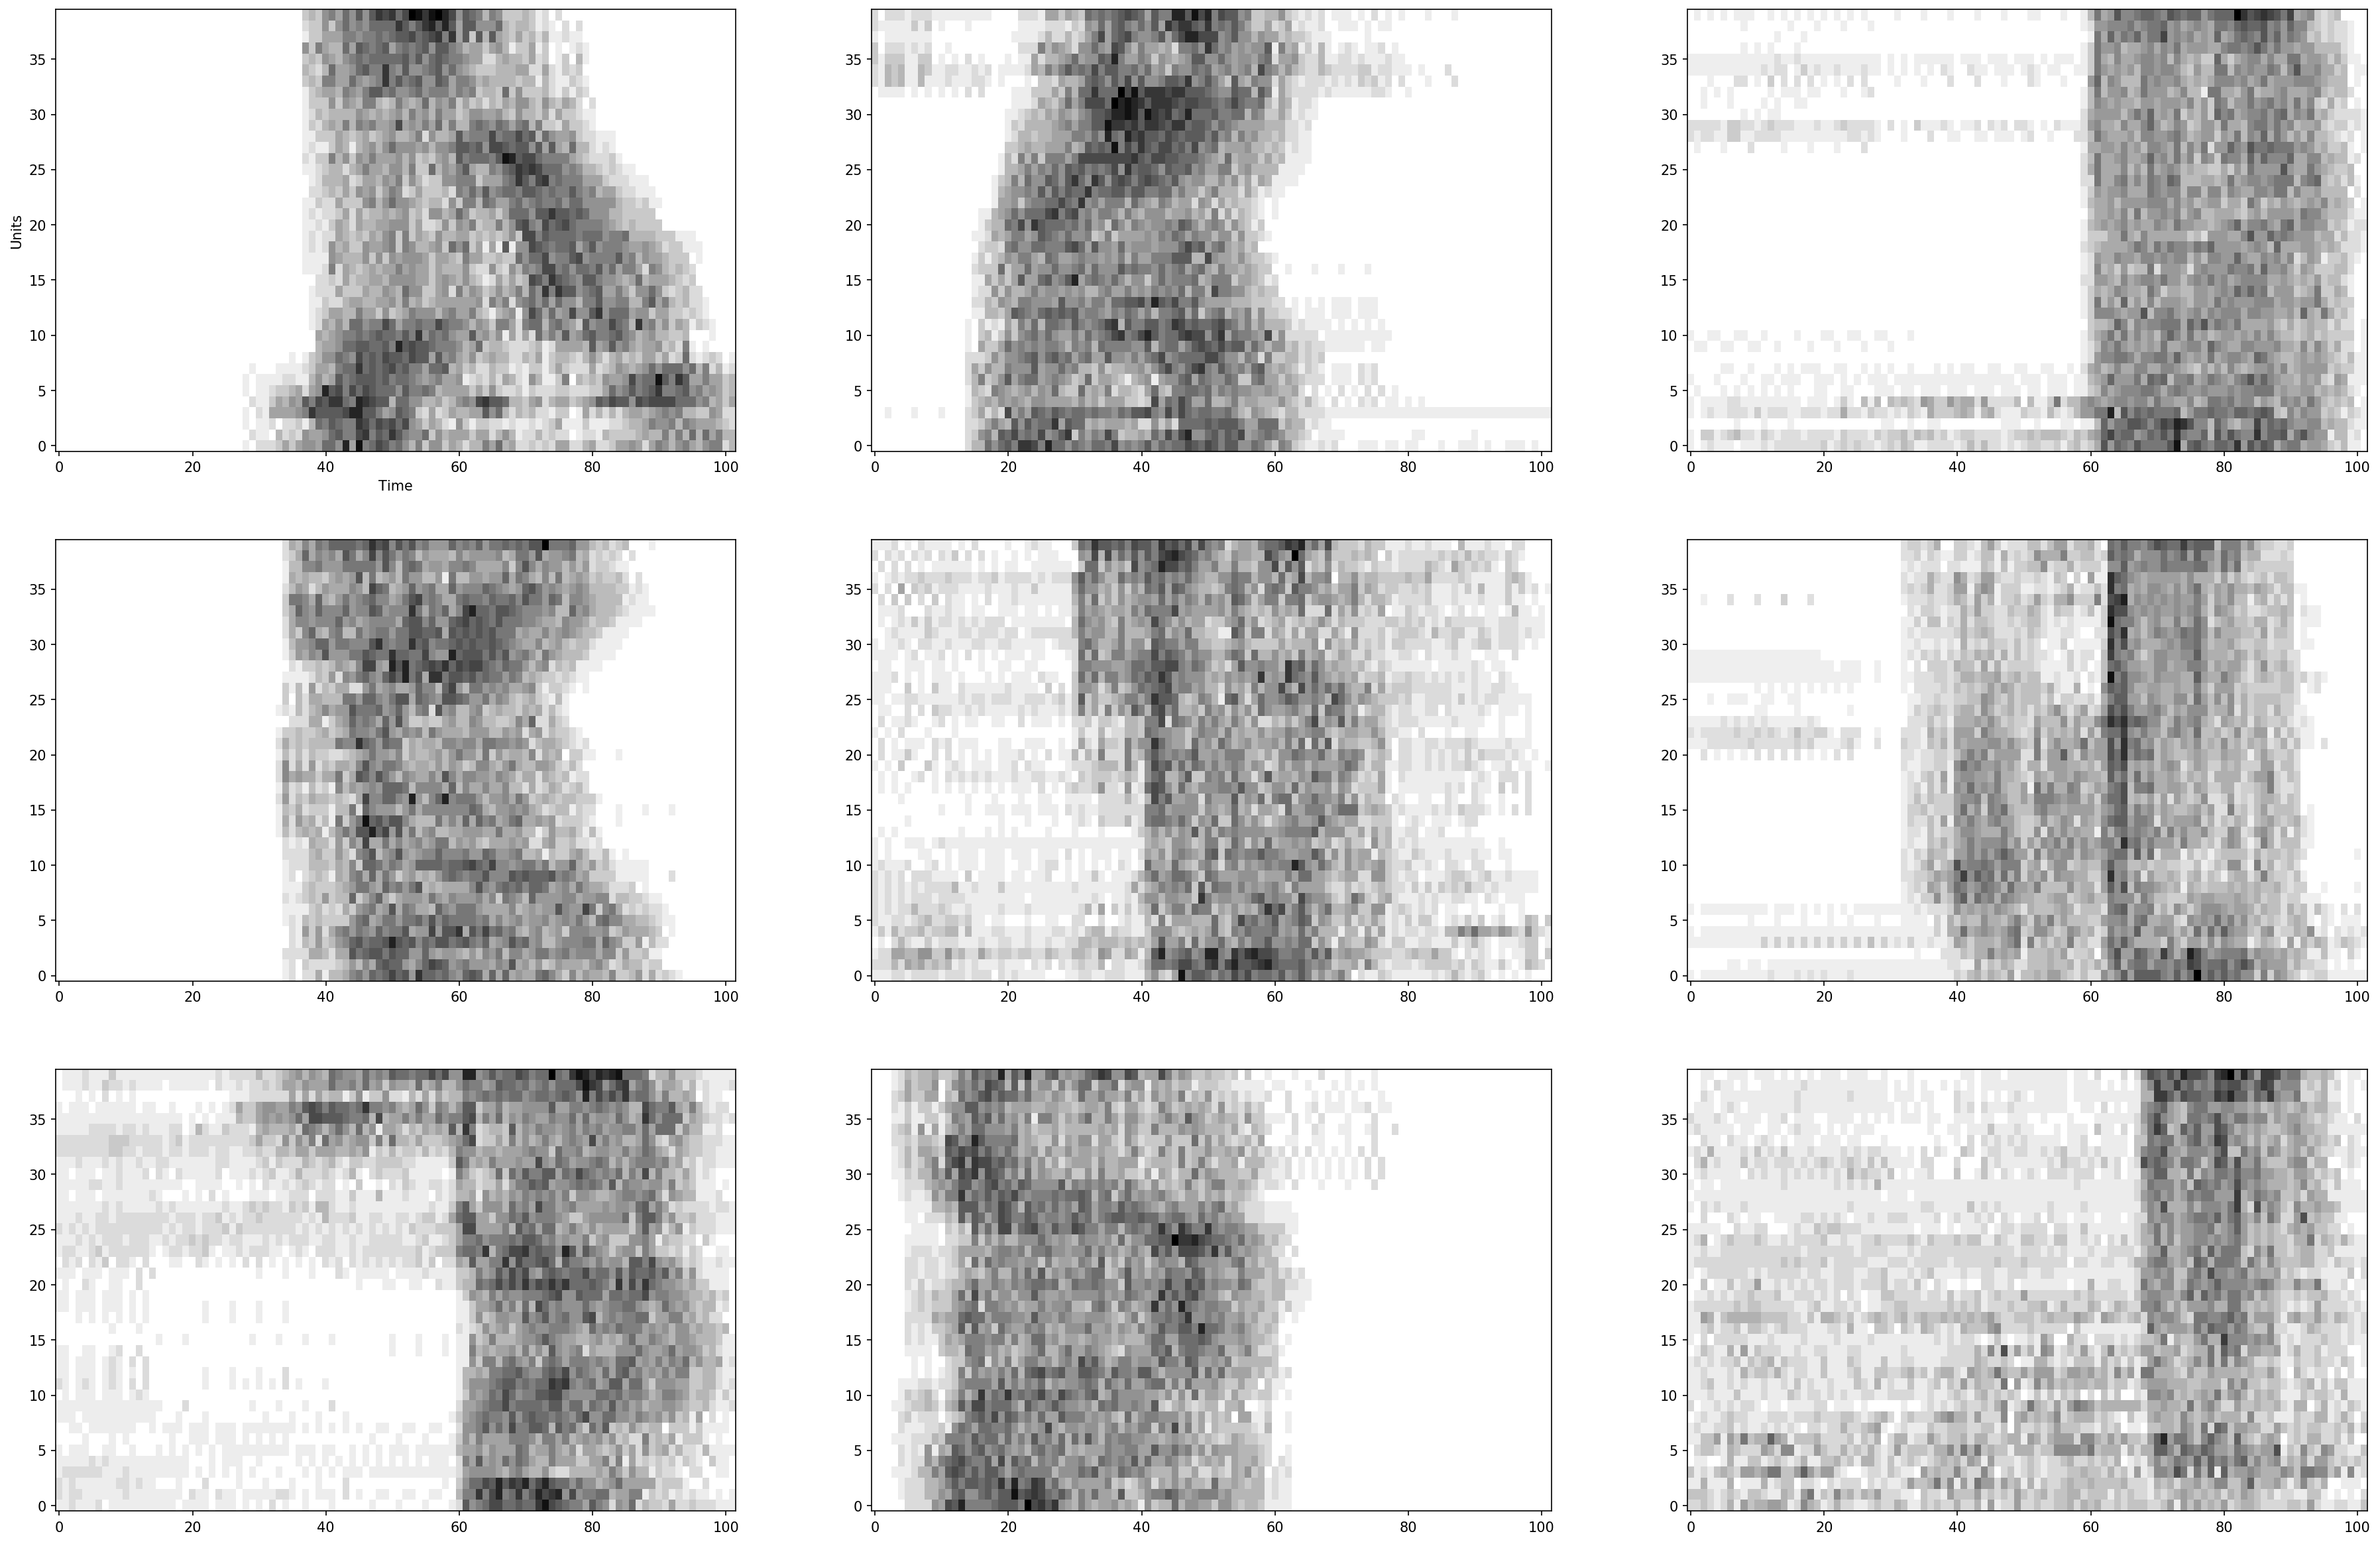

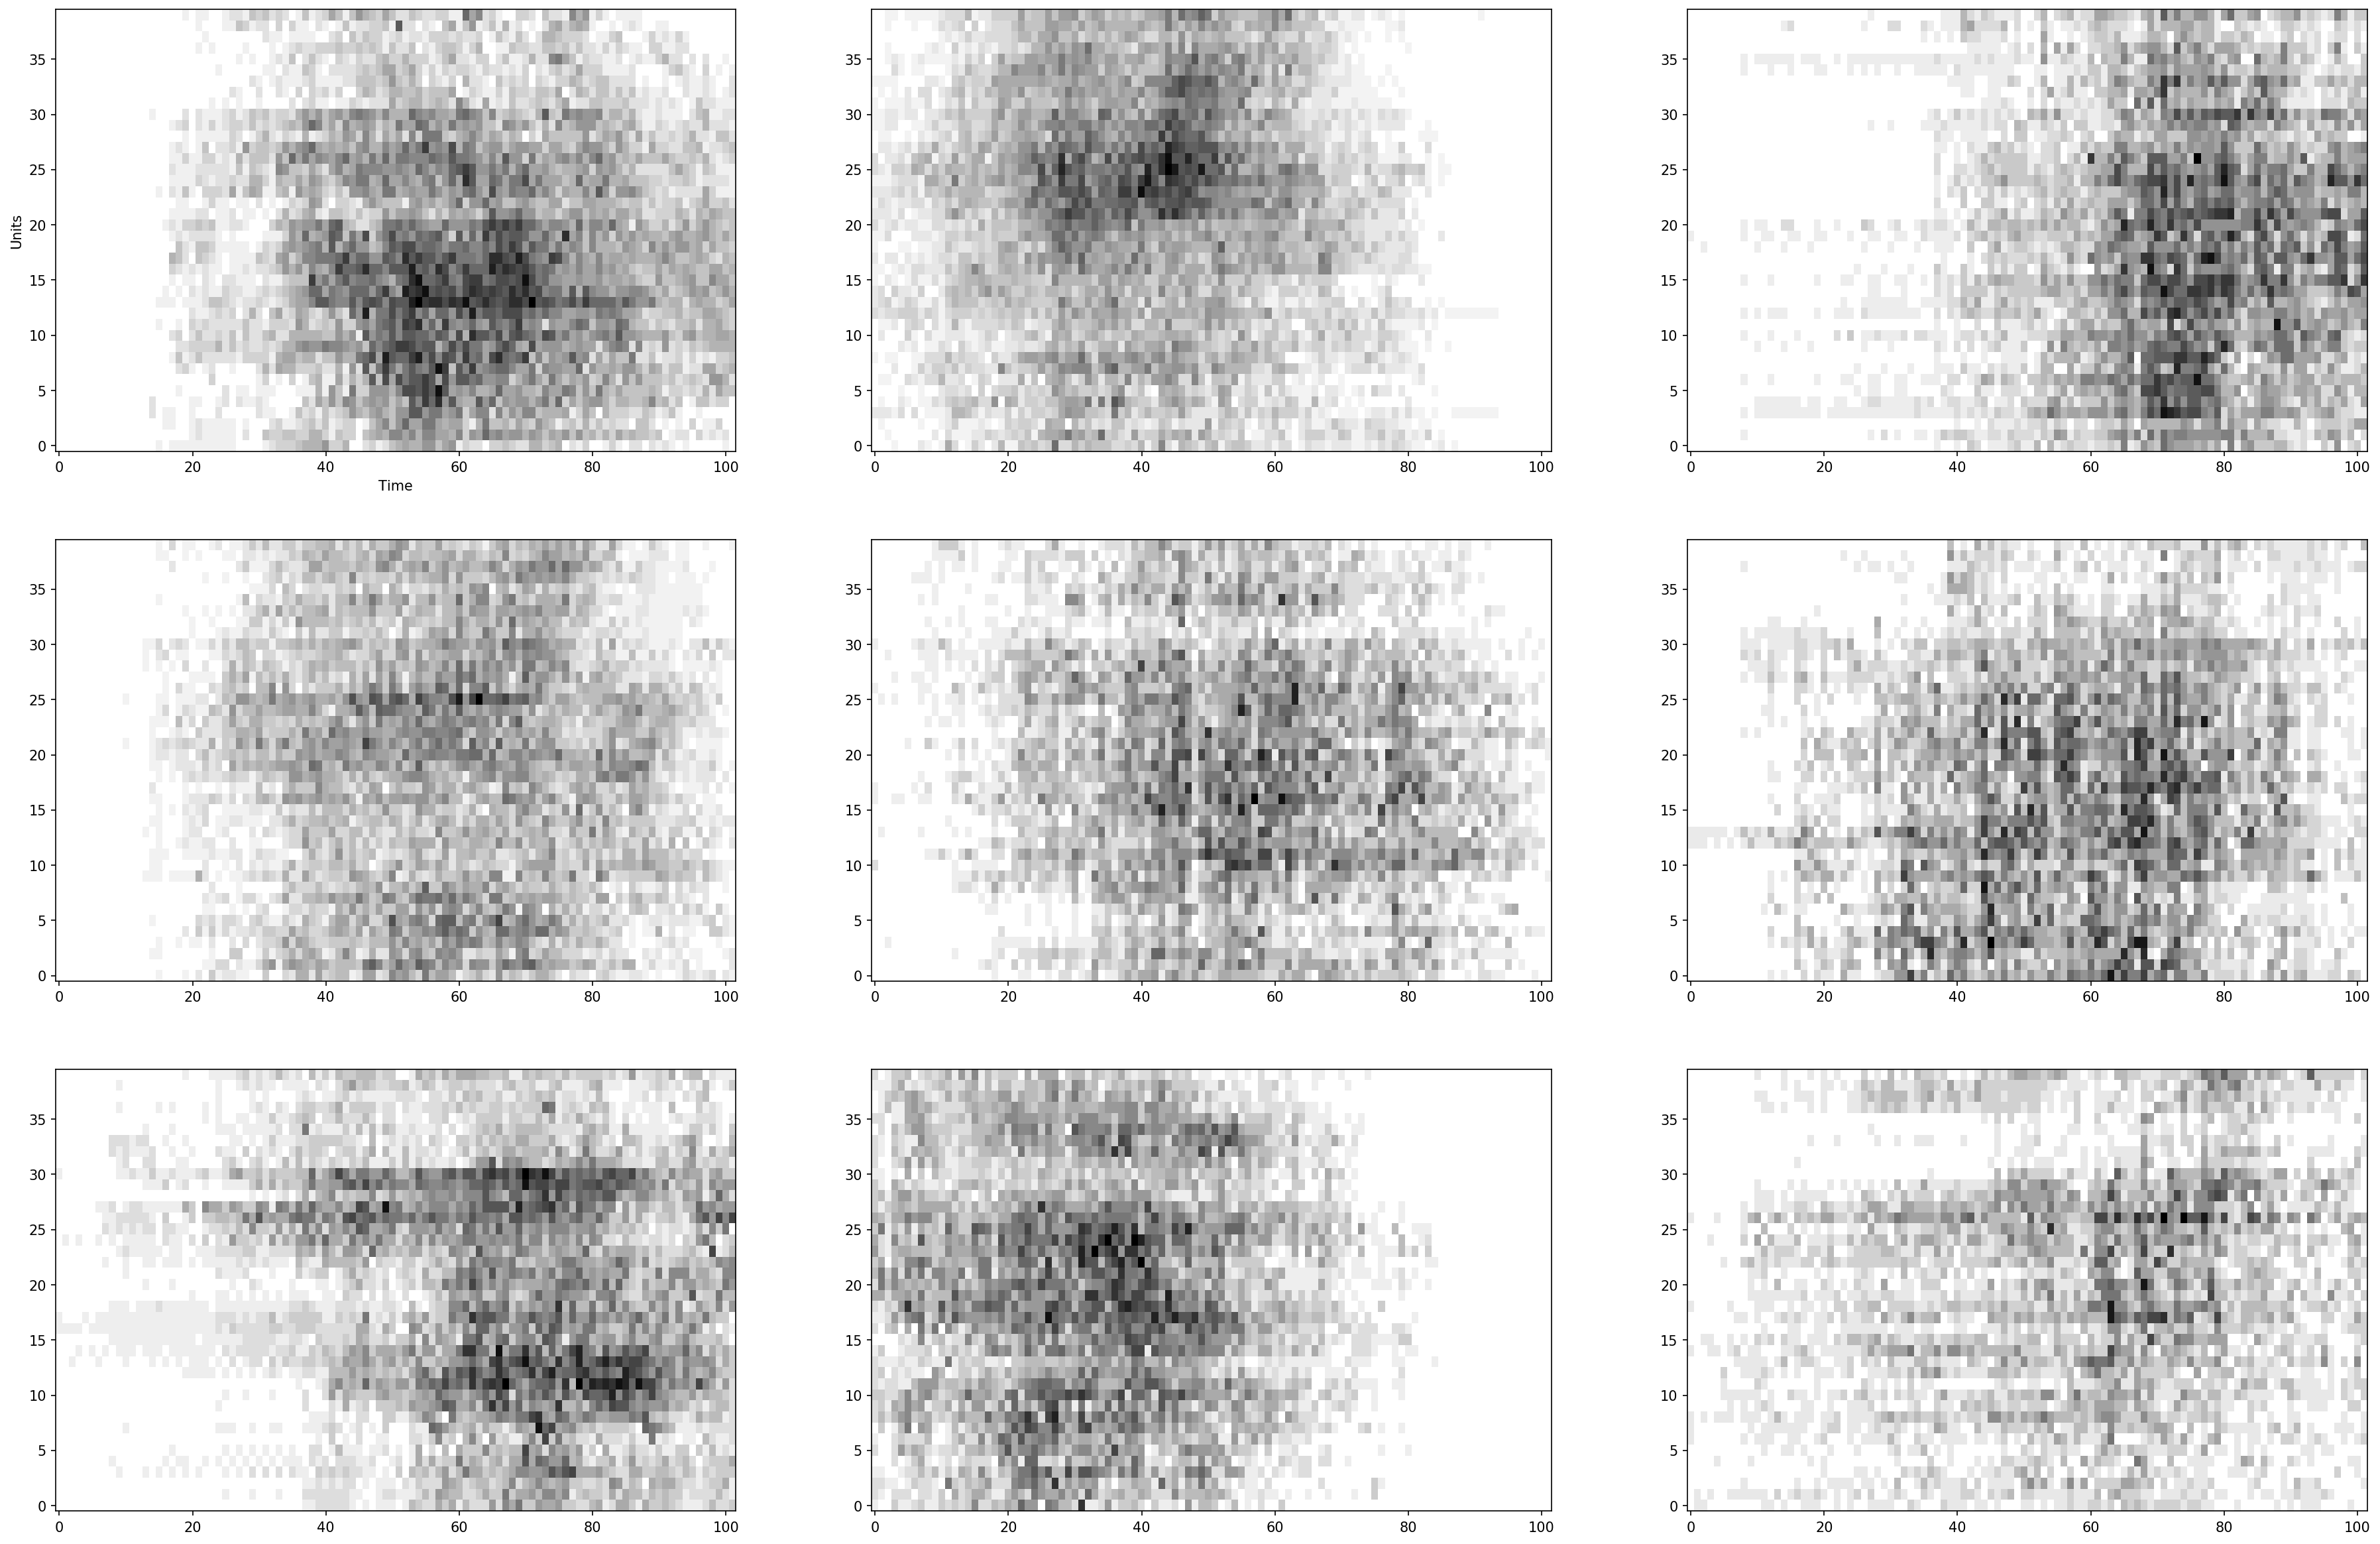

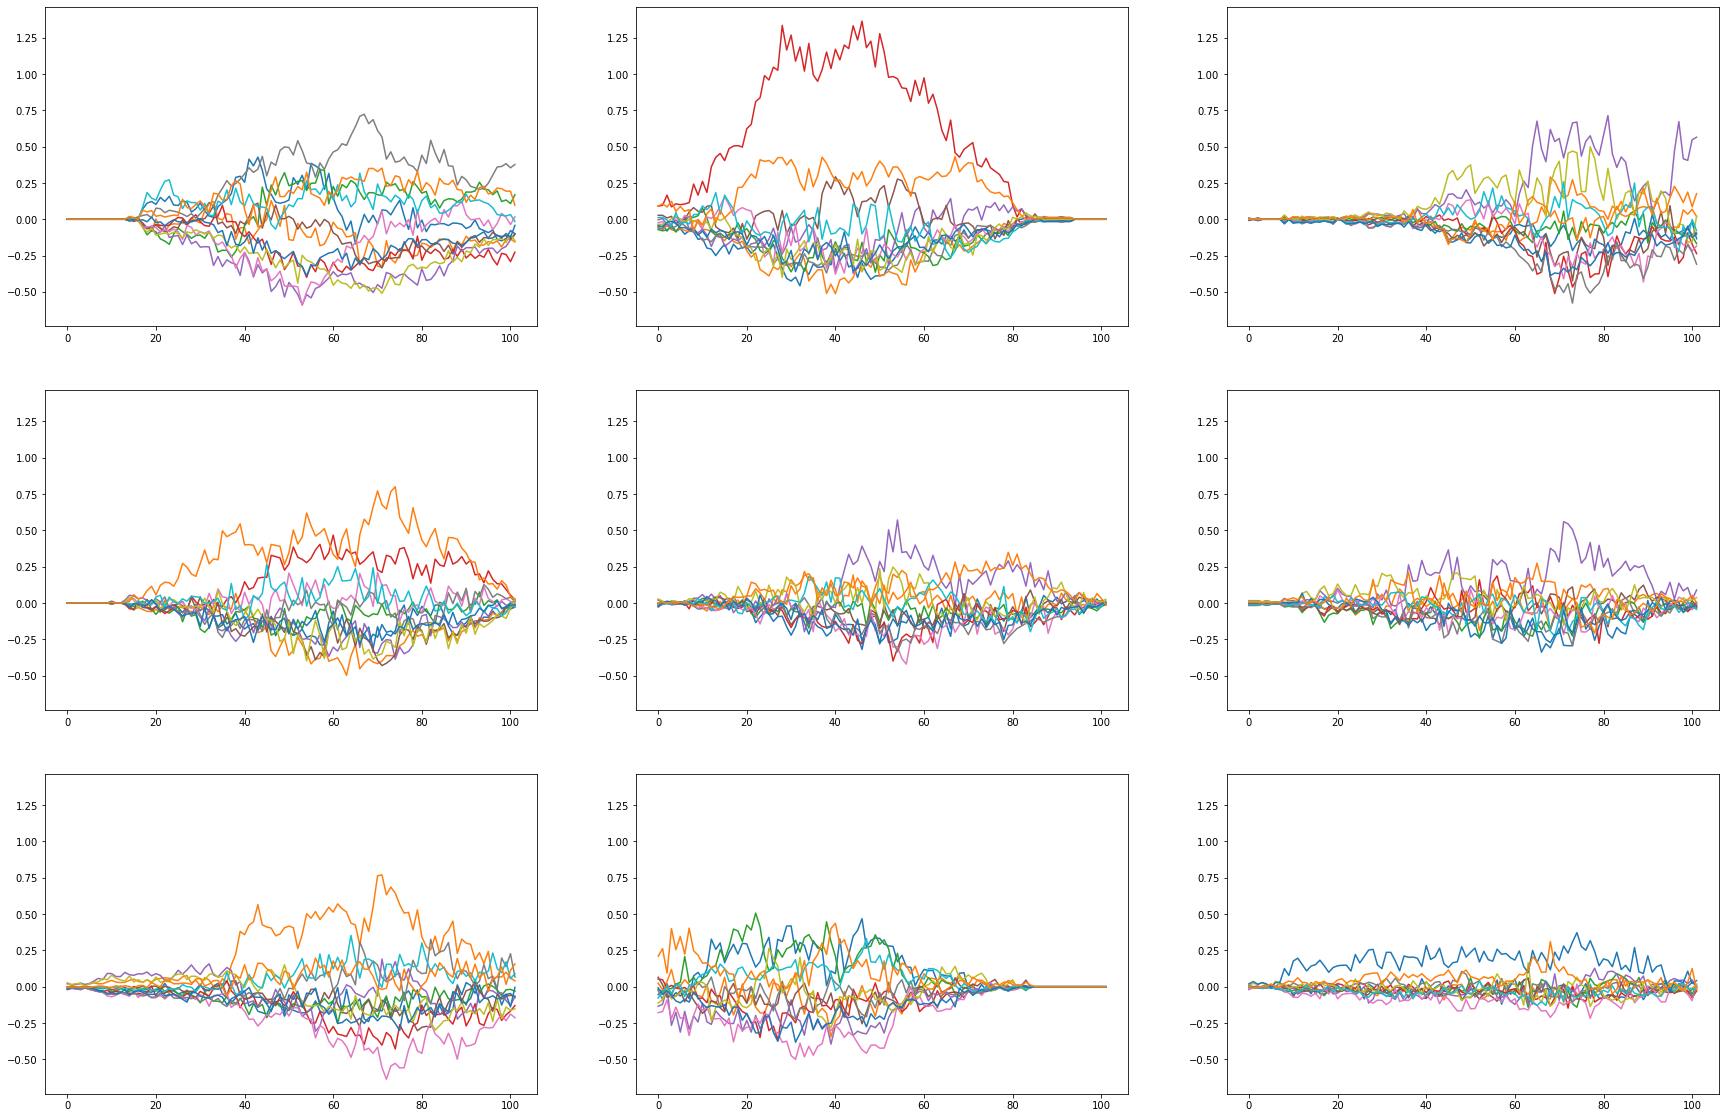

In [17]:
snn(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)